In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('DATA/gene_expression.csv')

In [5]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


<Axes: xlabel='Gene One', ylabel='Gene Two'>

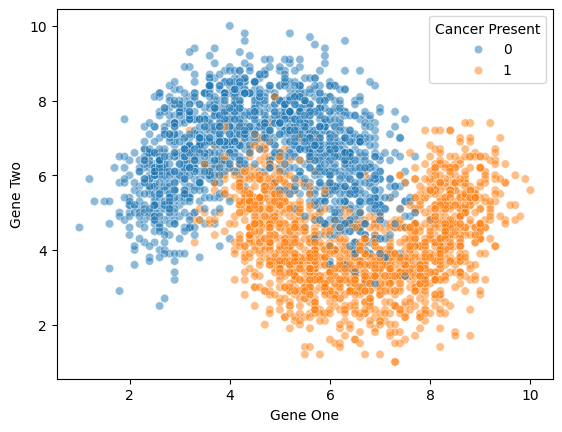

In [6]:
sns.scatterplot(data=df, x='Gene One', y='Gene Two', hue='Cancer Present', alpha=0.5)

In [7]:
len(df)

3000

(4.0, 8.0)

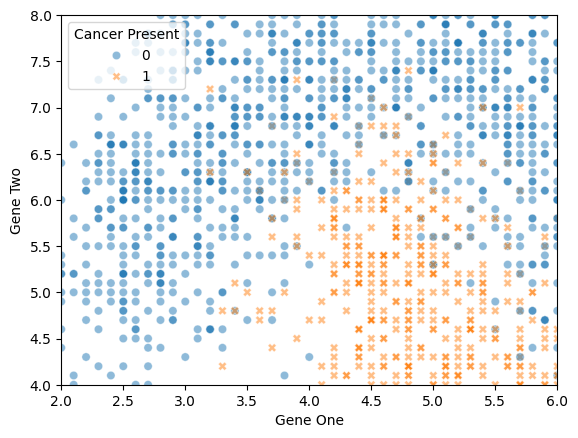

In [8]:
# Смотрим детальнее, увеличиваем фрагмент графика
sns.scatterplot(data=df, x='Gene One', y='Gene Two', hue='Cancer Present', alpha=0.5, style='Cancer Present')
plt.xlim(2,6)
plt.ylim(4,8)

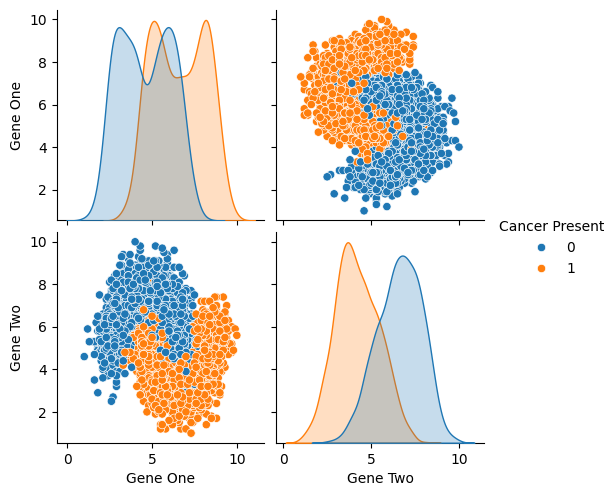

In [9]:
sns.pairplot(data=df, hue='Cancer Present')

In [10]:
# для метода KNN делать масштабирование нужно обязательно, тк в методе используется расстояние
from sklearn.model_selection import train_test_split

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [14]:
scaler = StandardScaler()

In [15]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [18]:
knn_model.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [19]:
y_pred = knn_model.predict(scaled_X_test)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
confusion_matrix(y_test, y_pred) # модель ошиблась в 46 + 49 случаев

array([[424,  46],
       [ 49, 381]])

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       470
           1       0.89      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



In [23]:
df['Cancer Present'].value_counts()

Cancer Present
1    1500
0    1500
Name: count, dtype: int64

In [24]:
from sklearn.metrics import accuracy_score

In [26]:
test_error_rates = []

for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train, y_train)

    y_pred = knn_model.predict(scaled_X_test)

    test_error = 1 - accuracy_score(y_test, y_pred)

    test_error_rates.append(test_error)

(0.0, 0.11)

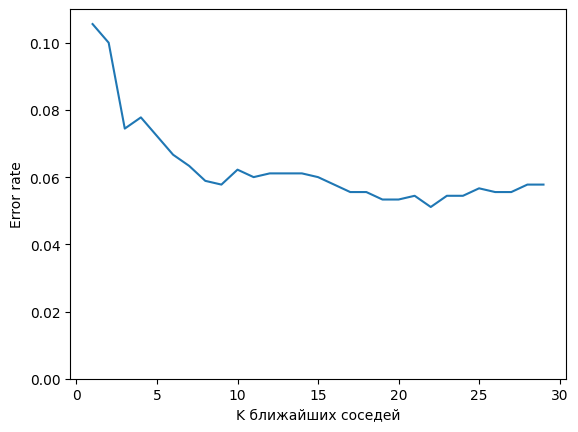

In [36]:
plt.plot(range(1,30), test_error_rates)
plt.ylabel('Error rate')
plt.xlabel('K ближайших соседей')
plt.ylim(0,0.11)

In [ ]:
# Создаем свой pipeline

In [37]:
scaler = StandardScaler()

In [38]:
knn = KNeighborsClassifier()

In [39]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [40]:
operations = [('scaler', scaler),('knn', knn)]

In [41]:
from sklearn.pipeline import Pipeline

In [42]:
pipe = Pipeline(operations)

In [43]:
from sklearn.model_selection import GridSearchCV

In [47]:
k_values = list(range(1,30+1))

In [49]:
print(k_values)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [50]:
param_grid = {'knn__n_neighbors':k_values}

In [51]:
full_cv_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

In [52]:
full_cv_classifier.fit(X_train, y_train) # здесь передаем исходные, тк шаг по масштабированию признаков находится внутри pipeline

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30]},
             scoring='accuracy')

In [53]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=20))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=20),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 20,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [55]:
full_pred = full_cv_classifier.predict(X_test)

In [56]:
print(classification_report(y_test, full_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



In [58]:
new_patient = [[3.8, 6.4]]
full_cv_classifier.predict(new_patient)
# рак отсутствует

/Users/sanakulov/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0])

In [59]:
full_cv_classifier.predict_proba(new_patient)

/Users/sanakulov/.pyenv/versions/3.13.0/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.9, 0.1]])